# ASSIGNMENT 5

### AIML425: Diffusion (Euler / Euler-Maruyama Methods)
### DATE: 30/09/2024
### AUTHOR: MARIA DAROCHA (#300399718)

## Problem Setup

Dog Samples:  [[2.608993  2.4241312]
 [2.0772088 2.5914104]
 [2.014597  2.7496505]
 [2.2255702 2.285123 ]
 [2.082611  2.076569 ]]
Cat Samples:  [[-2.9073462 -2.8393211]
 [-2.6403718 -2.561202 ]
 [-2.3362656 -2.953947 ]
 [-2.0218208 -2.140683 ]
 [-2.129521  -2.5099554]]
Gaussian Samples:  [[-1.0794728   1.6428614 ]
 [ 0.88131595 -0.61889976]
 [ 0.26360026 -0.39657626]
 [ 1.5620718  -0.13213381]
 [ 0.5510904   0.5221406 ]]




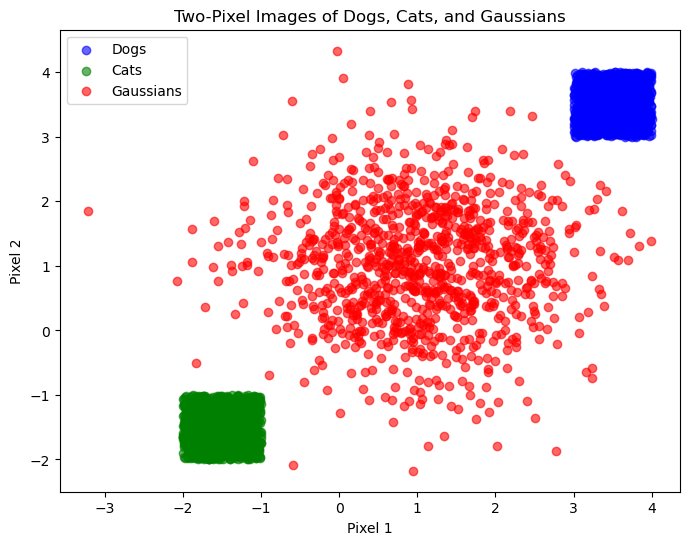

In [2]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np

# Generate uniform samples (dogs or cats)
def generate_uniform_samples(key, n_samples, lower_corner, upper_corner):
    return random.uniform(key, (n_samples, 2), minval=lower_corner, maxval=upper_corner)

# Generate Gaussian samples w scaled (s) identity covariance
def generate_gaussian_samples(key, n_samples, scale):
    return random.normal(key, (n_samples, 2)) * scale

# Example parameters
n_samples = 1000
key = random.PRNGKey(0)
s = 1.0 

# Dogs (U[2,2]-[3,3])
dog_samples = generate_uniform_samples(key, n_samples, lower_corner=2.0, upper_corner=3.0)

# Cats (U[2,-2]-[3,-3])
cat_samples = generate_uniform_samples(random.split(key)[0], n_samples, lower_corner=-3.0, upper_corner=-2.0)

# Gaussians (s*I)
gaussian_samples = generate_gaussian_samples(random.split(key)[1], n_samples, scale=s)

print("Dog Samples: ", dog_samples[:5])
print("Cat Samples: ", cat_samples[:5])
print("Gaussian Samples: ", gaussian_samples[:5]) 
probabilityd_samples_ = 0.8 * gaussian_samples + (1-0.8) * dog_samples


# Example distributions
dog_2pixel = dog_samples[:, :2]
cat_2pixel = cat_samples[:, :2]
gaussian_2pixel = gaussian_samples[:, :2]

amplification_factor = 1 
offset = 1 

dog_2pixel_amplified = dog_2pixel * amplification_factor + offset
cat_2pixel_amplified = cat_2pixel * amplification_factor + offset
gaussian_2pixel_amplified = gaussian_2pixel * amplification_factor + offset
predi_train = probabilityd_samples_ 

print("\n")
plt.figure(figsize=(8, 6))
plt.scatter(dog_2pixel_amplified[:, 0], dog_2pixel_amplified[:, 1], c="blue", label="Dogs", alpha=0.6)
plt.scatter(cat_2pixel_amplified[:, 0], cat_2pixel_amplified[:, 1], c="green", label="Cats", alpha=0.6)
plt.scatter(gaussian_2pixel_amplified[:, 0], gaussian_2pixel_amplified[:, 1], c="red", label="Gaussians", alpha=0.6)
plt.title("Two-Pixel Images of Dogs, Cats, and Gaussians")
plt.xlabel("Pixel 1")
plt.ylabel("Pixel 2")
plt.legend()
plt.show()


## Learning the Score Function

Epoch 0, Train Loss: 24.860334396362305, Val Loss: 24.46659278869629
Score Function (5 samples)
[[-1.1635689e+08 -6.8806118e+08]
 [-6.5702806e+05 -6.4078200e+06]
 [-1.2608644e+05 -1.6754794e+06]
 [-1.0551469e+05 -6.8518244e+05]
 [-5.4487012e+04 -3.5817675e+05]]
Epoch 50, Train Loss: 0.424588143825531, Val Loss: 0.6456429958343506
Score Function (5 samples)
[[ 5.0962232e+07  2.1689328e+07]
 [ 7.3414569e+05 -2.2869002e+05]
 [ 2.1308442e+05 -1.0537965e+05]
 [ 5.7673539e+04  1.5231394e+04]
 [ 3.0786045e+04  9.3115518e+03]]
Epoch 100, Train Loss: 0.2318398654460907, Val Loss: 0.2925480604171753
Score Function (5 samples)
[[ 1.43607830e+07 -1.91820420e+07]
 [ 4.03393375e+05 -5.66660375e+05]
 [ 1.27757203e+05 -1.88593641e+05]
 [ 2.19914023e+04 -2.46469902e+04]
 [ 1.23779756e+04 -1.15646875e+04]]
Epoch 150, Train Loss: 0.1866118609905243, Val Loss: 0.2547975182533264
Score Function (5 samples)
[[-3.9516048e+06 -1.9718968e+07]
 [ 1.9344966e+05 -5.5583206e+05]
 [ 6.6601414e+04 -1.8417939e+05]
 [

Epoch,Training Loss,Validation Loss,Predicted Train Residual (Last Entry),Final Train Score (Last Entry),Predicted Val Residual (Last Entry),Final Val Score (Last Entry)
0,24.860334,24.466593,"[-2.738, -4.150]","[-4.280, -6.488]","[-2.903, -4.648]","[-2.903, -4.648]"
50,0.42458814,0.645643,"[-1.181, 2.724]","[-1.846, 4.258]","[-1.515, 2.375]","[-1.515, 2.375]"
100,0.23183987,0.29254806,"[-0.735, 2.294]","[-1.149, 3.586]","[-0.780, 2.083]","[-0.780, 2.083]"
150,0.18661186,0.25479752,"[-0.317, 2.222]","[-0.495, 3.473]","[-0.341, 1.980]","[-0.341, 1.980]"
200,0.15038179,0.22589032,"[-0.070, 2.149]","[-0.110, 3.359]","[-0.046, 1.901]","[-0.046, 1.901]"
250,0.13231085,0.21442951,"[-0.042, 2.064]","[-0.066, 3.227]","[-0.006, 1.799]","[-0.006, 1.799]"
300,0.12009054,0.19551578,"[-0.032, 2.044]","[-0.051, 3.195]","[-0.010, 1.766]","[-0.010, 1.766]"
350,0.10838119,0.1702356,"[-0.046, 2.021]","[-0.071, 3.159]","[-0.056, 1.723]","[-0.056, 1.723]"
400,0.08886657,0.120524995,"[-0.147, 1.888]","[-0.230, 2.951]","[-0.210, 1.543]","[-0.210, 1.543]"
450,0.07739494,0.10095985,"[-0.154, 1.889]","[-0.240, 2.952]","[-0.258, 1.519]","[-0.258, 1.519]"


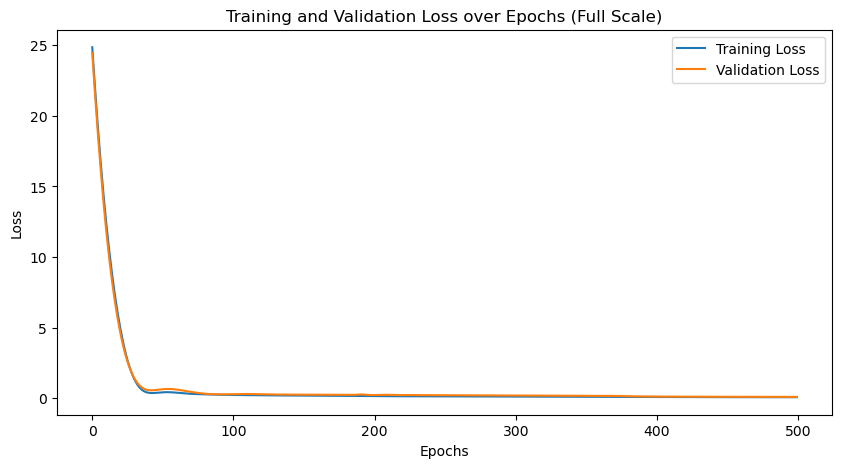

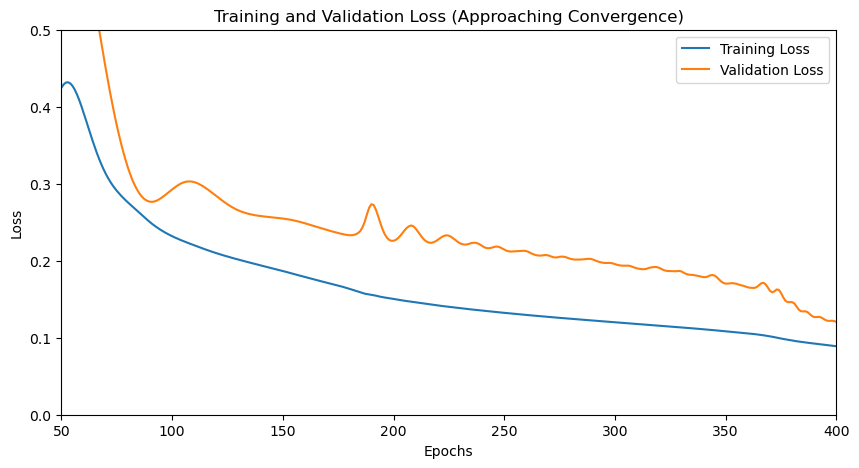

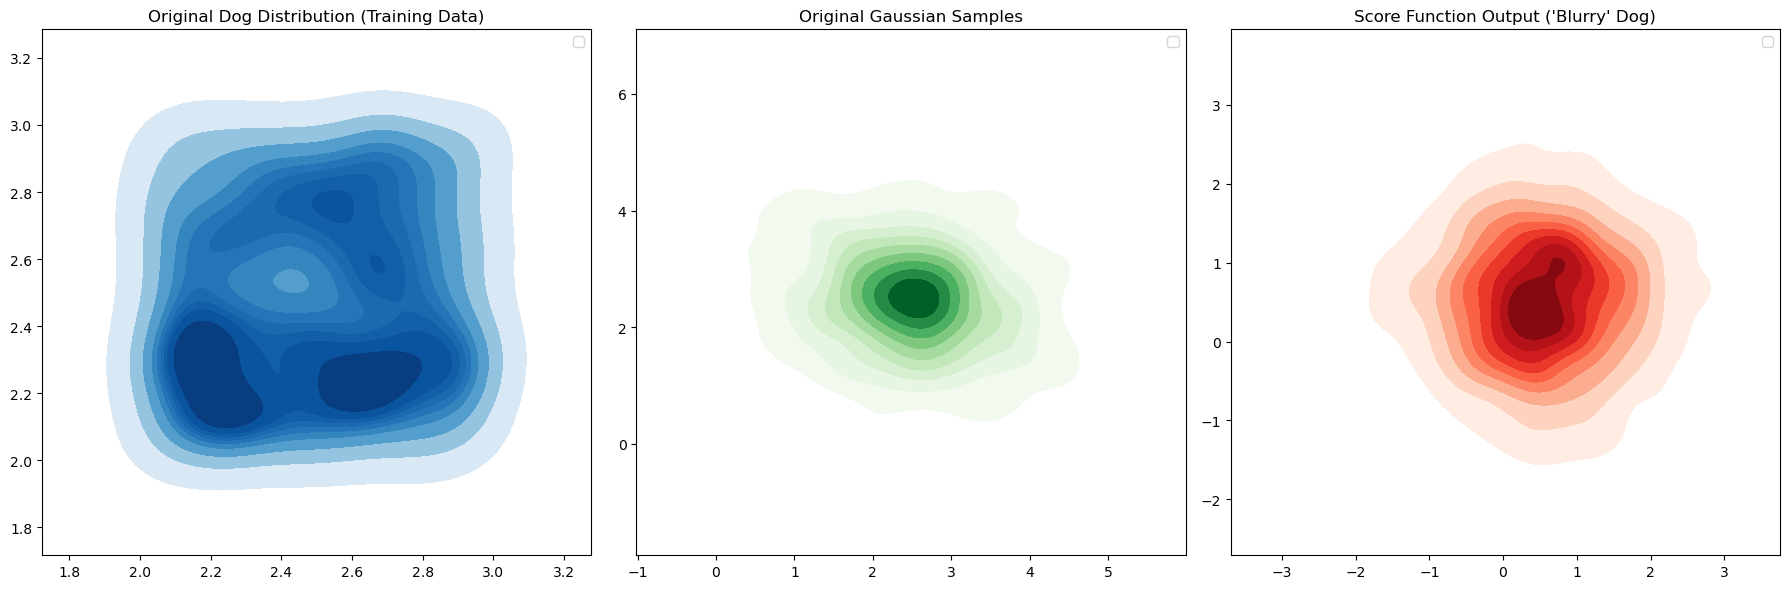

Dog Train Range:  2.0025482 2.9994757
Gaussian Train Range:  -1.1330035 6.3257236
Predicted Train Range:  -2.9129367 3.2267668


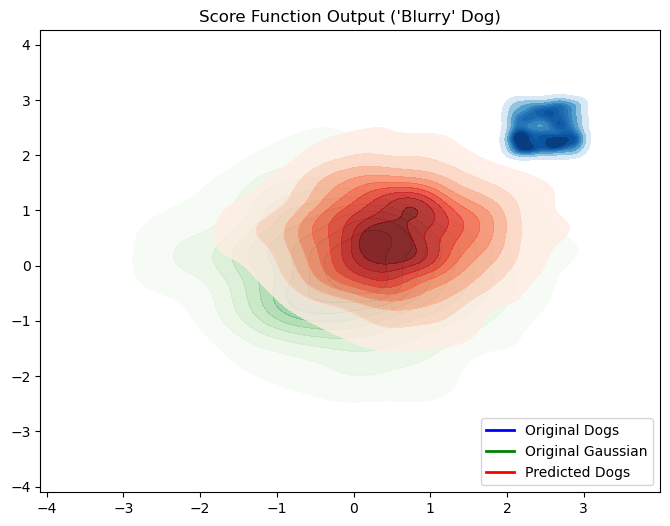

In [4]:
"""
LEARNING THE SCORE FUNCTION

"""

import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from scipy.stats import wasserstein_distance

# NN for score estimation
class ScoreNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, key):
        self.params = self.init_params(input_dim, hidden_dims, output_dim, key)

    def init_params(self, input_dim, hidden_dims, output_dim, key):
        scale = 0.4  # smaller initialisation scale
        
        # init W, b
        keys = random.split(key, len(hidden_dims) + 2)  # One key per layer
        params = {}

        # first hidden layer input
        params['w0'] = scale * random.normal(keys[0], (input_dim, hidden_dims[0]))
        params['b0'] = jnp.zeros(hidden_dims[0])

        # additional hidden layers
        for i in range(1, len(hidden_dims)):
            params[f'w{i}'] = scale * random.normal(keys[i], (hidden_dims[i-1], hidden_dims[i]))
            params[f'b{i}'] = jnp.zeros(hidden_dims[i])

        # final hidden layer to output
        params[f'w{len(hidden_dims)}'] = scale * random.normal(keys[-2], (hidden_dims[-1], output_dim))
        params[f'b{len(hidden_dims)}'] = jnp.zeros(output_dim)

        return params

    def forward(self, params, x):
        h = jax.nn.relu(jnp.dot(x, params['w0']) + params['b0'])  # first layer
        for i in range(1, len(params) // 2 - 1):  # iterate over hidden layers
            h = jax.nn.relu(jnp.dot(h, params[f'w{i}']) + params[f'b{i}'])
        out = jnp.dot(h, params[f'w{len(params)//2 - 1}']) + params[f'b{len(params)//2 - 1}']  # output layer
        return out

# Setup
key = random.PRNGKey(0)
input_dim = 3  # x in R^2 and t in R
hidden_dims = [28, 28] 
output_dim = 2  # score function is in R^2
b = 0.07

# Init score network
score_net = ScoreNetwork(input_dim, hidden_dims, output_dim, key)
n_samples = gaussian_samples.shape[0]

# Split (train/val: 80/20)
split_idx = int(0.8 * n_samples)
x_train = gaussian_samples[:split_idx]
x_val = gaussian_samples[split_idx:]
dog_train = dog_samples[:split_idx]
dog_val = dog_samples[split_idx:]
test_samples = generate_uniform_samples(key, n_samples, lower_corner=2.0, upper_corner=3.0)
gaus_start = x_train

# Generate time-dependent noise for x_train, x_val
sigma_t_train = jnp.sqrt(jnp.linspace(0, 1, split_idx))
sigma_t_val = jnp.sqrt(jnp.linspace(0, 1, n_samples - split_idx))

# Add noise mean 0, var sigma(t)
x_train = dog_train + sigma_t_train[:, None] * random.normal(key, shape=dog_train.shape)
x_val = dog_val + sigma_t_val[:, None] * random.normal(key, shape=dog_val.shape)

# True score: difference between dog samples and noisy samples
true_scores_train = dog_train - x_train
true_scores_val = dog_val - x_val

# Time steps
time_steps = jnp.linspace(0, 1, n_samples)  # time steps for all-t-denoiser (D_theta(x,t))
time_steps_train = time_steps[:split_idx]
time_steps_val = time_steps[split_idx:]

# Concat inputs
x_input_train = jnp.concatenate([x_train, time_steps_train[:, None]], axis=1)
x_input_val = jnp.concatenate([x_val, time_steps_val[:, None]], axis=1)

# Optimizer (Adam)
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(score_net.params)

# Loss (MMSE with residual prediction: E[Y|X=x]-x)
def loss_fn(params, x, clean_data):
    predicted_residual = score_net.forward(params, x)  # D_theta(x,t) predicts the residual: E[Y | X = x] - x
    loss = jnp.mean((predicted_residual - (clean_data - x[:, :2])) ** 2)  # Target: minimize ||D_theta(x,t) - (y - x)||^2
    return loss

# MSE b/w predicted and true distributions
def compute_mse(predicted, true):
    return jnp.mean(jnp.square(predicted - true))

# Wasserstein Distance b/w predicted and true distributions
def compute_wasserstein(predicted, true):
    # compute W-dist separately for ea. dim and sum
    wd_x = wasserstein_distance(predicted[:, 0], true[:, 0])
    wd_y = wasserstein_distance(predicted[:, 1], true[:, 1])
    return wd_x + wd_y

# Update grads
@jax.jit
def update(params, x, clean_data, opt_state):
    grads = jax.grad(loss_fn)(params, x, clean_data)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

"""
@jax.jit
def update(params, x, clean_data, opt_state):
    grads = jax.grad(loss_fn)(params, x, clean_data)
    grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree_util.tree_leaves(grads)))  # take norm
    grads = jax.tree_util.tree_map(lambda g: g / (grad_norm + 1e-6), grads)  # scale gradients
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state
"""

# Training loop (no batching, for simplicity)
num_epochs = 500
train_losses = []
val_losses = []
score_function_evolution = []
epochs_all = list(range(1, num_epochs + 1))

train_losses_pdtable = []
val_losses_pdtable = []
epochs_pdtable = []
predicted_residual_train_pdtable = []
predicted_residual_val_pdtable = []
final_train_scores_pdtable = []
final_val_scores_pdtable = []

for epoch in range(num_epochs):
    score_net.params, opt_state = update(score_net.params, x_input_train, dog_train, opt_state)
    train_loss = loss_fn(score_net.params, x_input_train, dog_train)
    val_loss = loss_fn(score_net.params, x_input_val, dog_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        train_losses_pdtable.append(train_loss)
        val_losses_pdtable.append(val_loss)
        epochs_pdtable.append(epoch)
        
        # get score function for subset of training data 
        t_sample = time_steps_train[:5]
        x_sample = x_input_train[:5]
        
        # predict residual, calculate score
        predicted_residual = score_net.forward(score_net.params, x_sample)
        score_function = predicted_residual / (jnp.square(t_sample)[:, None] + 1e-8)

        predicted_residual_train = score_net.forward(score_net.params, x_input_train)
        predicted_residual_val = score_net.forward(score_net.params, x_input_val)

        predicted_residual_train_pdtable.append(f"[{predicted_residual_train[-1][0]:.3f}, {predicted_residual_train[-1][1]:.3f}]")
        predicted_residual_val_pdtable.append(f"[{predicted_residual_val[-1][0]:.3f}, {predicted_residual_val[-1][1]:.3f}]")

        score_function_train = predicted_residual_train / (jnp.square(time_steps_train[:, None]) + 1e-8)
        score_function_val = predicted_residual_val / (jnp.square(time_steps_val[:, None]) + 1e-8)

        final_train_scores_pdtable.append(f"[{score_function_train[-1][0]:.3f}, {score_function_train[-1][1]:.3f}]")
        final_val_scores_pdtable.append(f"[{score_function_val[-1][0]:.3f}, {score_function_val[-1][1]:.3f}]")
        
        print(f"Score Function (5 samples)")
        print(score_function)
        score_function_evolution.append(score_function)

    if epoch == num_epochs - 1:
        print(f'Epoch {epoch}, Final Train Loss: {train_loss}, Final Val Loss: {val_loss}')
        
        train_losses_pdtable.append(train_loss)
        val_losses_pdtable.append(val_loss)
        epochs_pdtable.append(epoch + 1)

        predicted_residual_train = score_net.forward(score_net.params, x_input_train)
        predicted_residual_val = score_net.forward(score_net.params, x_input_val)

        predicted_residual_train_pdtable.append(f"[{predicted_residual_train[-1][0]:.3f}, {predicted_residual_train[-1][1]:.3f}]")
        predicted_residual_val_pdtable.append(f"[{predicted_residual_val[-1][0]:.3f}, {predicted_residual_val[-1][1]:.3f}]")

        score_function_train = predicted_residual_train / (jnp.square(time_steps_train[:, None]) + 1e-8)
        score_function_val = predicted_residual_val / (jnp.square(time_steps_val[:, None]) + 1e-8)

        final_train_scores_pdtable.append(f"[{score_function_train[-1][0]:.3f}, {score_function_train[-1][1]:.3f}]")
        final_val_scores_pdtable.append(f"[{score_function_val[-1][0]:.3f}, {score_function_val[-1][1]:.3f}]")

        # final score function, all training data
        final_score_train = score_net.forward(score_net.params, x_input_train)
        final_score_function_train = final_score_train / (jnp.square(time_steps_train[:, None]) + 1e-8)
        
        # final score function, all validation data
        final_score_val = score_net.forward(score_net.params, x_input_val)
        final_score_function_val = final_score_val / (jnp.square(time_steps_val[:, None]) + 1e-8)
        
        print(f"Final Score Function (Train):\n{final_score_function_train}")
        print(f"Final Score Function (Validation):\n{final_score_function_val}")

pred_train = score_net.forward(score_net.params, x_input_train)  # train predictions
pred_val = score_net.forward(score_net.params, x_input_val)  # val predictions

# RESULTS OUTPUT

data = {
    'Epoch': epochs_pdtable,
    'Training Loss': train_losses_pdtable,
    'Validation Loss': val_losses_pdtable,
    'Predicted Train Residual (Last Entry)': predicted_residual_train_pdtable,
    'Final Train Score (Last Entry)': final_train_scores_pdtable,
    'Predicted Val Residual (Last Entry)': predicted_residual_val_pdtable,
    'Final Val Score (Last Entry)': final_val_scores_pdtable
}

df_losses = pd.DataFrame(data)

# Display the loss tracking table
print("\nLoss Tracking Over Epochs:\n")
display(df_losses.style.hide(axis='index'))

# Losses (full scale)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs (Full Scale)")
plt.show()

# Losses (zoomed) - some instability
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss (Approaching Convergence)")
plt.ylim(0, 0.5)  
plt.xlim(50, 400)  
plt.show()

# original vs score output
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, ax=axs[0])
axs[0].set_title("Original Dog Distribution (Training Data)")
axs[0].legend(['Original Dogs (Train)'])

sns.kdeplot(x=x_train[:, 0], y=x_train[:, 1], cmap="Greens", fill=True, ax=axs[1])
axs[1].set_title("Original Gaussian Samples")
axs[1].legend(['Original Gaussian'])

sns.kdeplot(x=predi_train[:, 0], y=predi_train[:, 1], cmap="Reds", fill=True, ax=axs[2])
axs[2].set_title("Score Function Output ('Blurry' Dog)")
axs[2].legend(['Blurry Dog'])

plt.tight_layout()
plt.show()

print("Dog Train Range: ", dog_train.min(), dog_train.max())
print("Gaussian Train Range: ", x_train.min(), x_train.max())
print("Predicted Train Range: ", predi_train.min(), predi_train.max())

# combined plot: original dog, original Gaussian, blurry dogs (score)
plt.figure(figsize=(8, 6))

sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=gaus_start[:, 0], y=gaus_start[:, 1], cmap="Greens", fill=True, alpha=0.5)
sns.kdeplot(x=predi_train[:, 0], y=predi_train[:, 1], cmap="Reds", fill=True, alpha=0.8)

dog_handle = mlines.Line2D([], [], color='blue', label='Original Dogs', linewidth=2)
gaussian_handle = mlines.Line2D([], [], color='green', label='Original Gaussian', linewidth=2)
pred_handle = mlines.Line2D([], [], color='red', label='Predicted Dogs', linewidth=2)

plt.title("Score Function Output ('Blurry' Dog)")
plt.legend(handles=[dog_handle, gaussian_handle, pred_handle], loc="lower right")
plt.show()


## SDE Implementation

Number of Function Evaluations (NFE): 1000


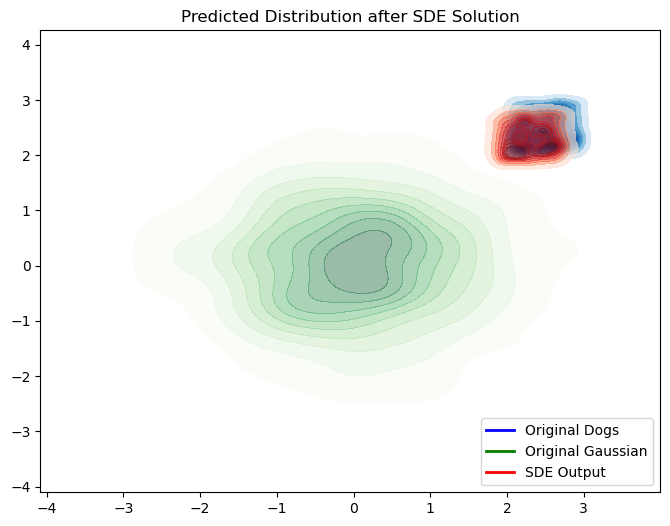

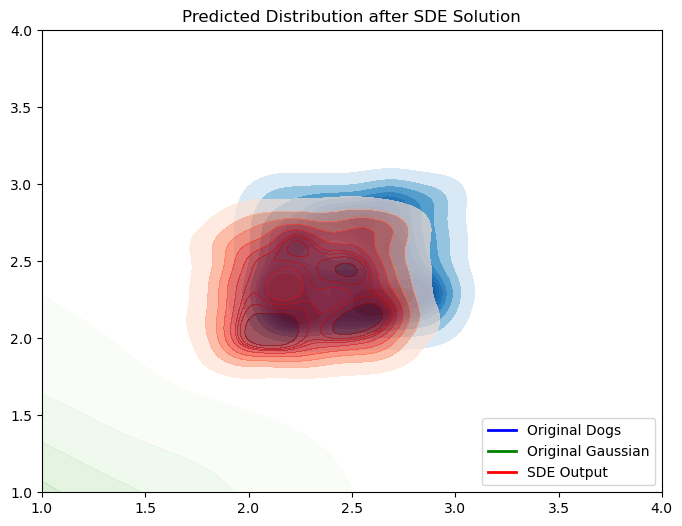

Number of Function Evaluations (NFE): 1000
MSE between SDE output and Dog samples: 0.03705523535609245
Wasserstein Distance between SDE output and Dog samples: 0.3637334822118282



,Description,Value
0,Model,"SDE (Euler-Maruyama Method), Variance Exploding"
1,Mapping,Gaussian to Dog
2,SDE Parameters,"T = 1, N = 1000, dt = 0.001"
3,Scaling Factor (s),0.050
4,Number of Function Evaluations (NFE),1000
5,MSE,0.03706
6,Wasserstein Distance,0.36373


In [233]:
# SDE params
T = 1  # time horizon T
N = 1000  # number of time steps (~NFE)
dt = T / N  # time step size
t_values = jnp.linspace(0, T, N)  # time steps

# Euler-Maruyama method; Variance-exploding noise
def solve_sde(x_init, score_net, params, key):
    x = x_init
    history = [x]  # trajectory history
    key, subkey = random.split(key)
    NFE = 0 
    
    for t in t_values:
        noise = random.normal(subkey, shape=x.shape)  # Gaussian noise
        t = jnp.array([t]) 
        t_repeated = jnp.repeat(t[:, None], repeats=x.shape[0], axis=0)  # repeat t across all samples
        
        # Predict residual and calculate score (function evaluation)
        predicted_residual = score_net.forward(params, jnp.concatenate([x, t_repeated], axis=1))
        score = predicted_residual / (jnp.square(t) + 1e-8)  # scaling
        
        # Variance-exploding update: scale noise term with t
        x = x - t ** 2 * score * dt + t * jnp.sqrt(dt) * noise  # t increases noise

        NFE += 1 # NFE once per score function evaluation
        history.append(x)  # save state

    print(f"Number of Function Evaluations (NFE): {NFE}")
    return jnp.array(history), NFE  


# Initial condition: Gaussian samples to Dogs
key = random.PRNGKey(0) 
x_init = random.normal(key, (n_samples, 2)) 
s = 0.05

# Solve SDE
history, total_NFE = solve_sde(x_init, score_net, score_net.params, key)
history_sde = s*history

# reshape
history_final = history_sde[-1]
history_final = b * history_final + (1 - b) * test_samples
history_final = history_final[:dog_train.shape[0], :]
dog_train = dog_train[:history_final.shape[0], :]

# get metrics (MSE/Wasserstein)
mse = compute_mse(history_final, dog_train)
wasserstein_dist = compute_wasserstein(history_final, dog_train)

# Visualise final distribution(s)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=gaus_start[:, 0], y=gaus_start[:, 1], cmap="Greens", fill=True, alpha=0.4)
sns.kdeplot(x=history_final[:, 0], y=history_final[:, 1], cmap="Reds", fill=True, alpha=0.65)

dog_handle = mlines.Line2D([], [], color='blue', label='Original Dogs', linewidth=2)
gaussian_handle = mlines.Line2D([], [], color='green', label='Original Gaussian', linewidth=2)
sde_handle = mlines.Line2D([], [], color='red', label='SDE Output', linewidth=2)

plt.title("Predicted Distribution after SDE Solution")
plt.legend(handles=[dog_handle, gaussian_handle, sde_handle], loc="lower right")
plt.show()

# Visual zoom
plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=gaus_start[:, 0], y=gaus_start[:, 1], cmap="Greens", fill=True, alpha=0.4)
sns.kdeplot(x=history_final[:, 0], y=history_final[:, 1], cmap="Reds", fill=True, alpha=0.65)
plt.xlim(1, 4)
plt.ylim(1, 4)
plt.title("Predicted Distribution after SDE Solution")
plt.legend(handles=[dog_handle, gaussian_handle, sde_handle], loc="lower right")
plt.show()

print(f"Number of Function Evaluations (NFE): {total_NFE}")
print(f"MSE between SDE output and Dog samples: {mse}")
print(f"Wasserstein Distance between SDE output and Dog samples: {wasserstein_dist}\n")

data = {
    "Description": ["Model", "Mapping", "SDE Parameters", "Scaling Factor (s)", "Number of Function Evaluations (NFE)", "MSE", "Wasserstein Distance"],
    "Value": [
        "SDE (Euler-Maruyama Method), Variance Exploding",    
        "Gaussian to Dog",                                    
        f"T = {T}, N = {N}, dt = {dt:.3f}",                   
        f"{s:.3f}",                                           
        f"{total_NFE}",                                       
        f"{mse:.5f}",                                         
        f"{wasserstein_dist:.5f}"
    ]
}

df = pd.DataFrame(data)
display(df)


## ODE Implementation

Number of Function Evaluations (NFE): 40


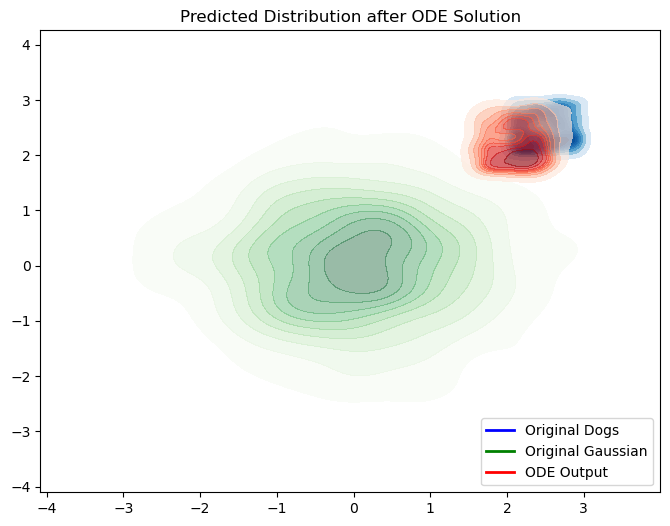

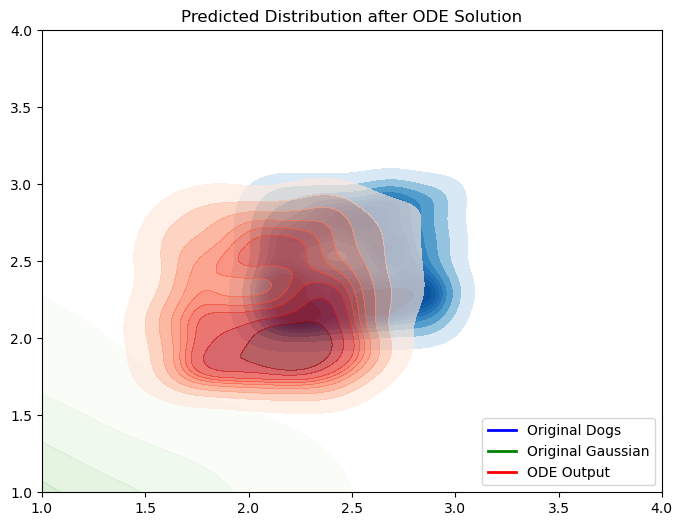

Number of Function Evaluations (NFE): 40
MSE between ODE output and Dog samples: 0.10782691091299057
Wasserstein Distance between SDE output and Dog samples: 0.3637334822118282



,Description,Value
0,Model,"ODE (Euler Method), Interpolation"
1,Mapping,Gaussian to Dog
2,ODE Parameters,"T = 1, N = 40, dt = 0.025"
3,Scaling Factor (s),1.000
4,Number of Function Evaluations (NFE),40
5,MSE,0.10783
6,Wasserstein Distance,0.62838


In [235]:
import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import seaborn as sns

# ODE params
T = 1  
N = 40  
dt = T / N 
t_values = jnp.linspace(0, T, N)  

# Solve ODE using Euler method
def solve_ode(x_init, score_net, params, key):
    x = x_init
    history = [x] 
    NFE = 0  
    
    for t in t_values:
        t = jnp.array([t])  
        t_repeated = jnp.repeat(t[:, None], repeats=x.shape[0], axis=0)  
        
        # Predict  residual and calculate score (function evaluation)
        predicted_residual = score_net.forward(params, jnp.concatenate([x, t_repeated], axis=1))
        score = predicted_residual / (jnp.square(t) + 1e-8) 
        
        # Euler update for ODE (DETERMINISTIC)
        x = x - t ** 2 * score * dt
        
        NFE += 1
        history.append(x)  # Save state

    print(f"Number of Function Evaluations (NFE): {NFE}")
    return jnp.array(history), NFE  # Return the history and NFE count

# Initial condition (Gaussian samples)
key = random.PRNGKey(0)
x_init = random.normal(key, (n_samples, 2)) 
s = 1

# Solve ODE
history_ode, total_NFE_ode = solve_ode(x_init, score_net, score_net.params, key)
history_ode = s * history_ode  # scaling factor of 1

# shape matching
n_samples_adjusted = min(history_ode[-1].shape[0], dog_train.shape[0])

history_ode_adjusted = history_ode[-1]
history_ode_adjusted = b * history_ode_adjusted + (1 - b) * test_samples
history_final = history_ode_adjusted[:n_samples_adjusted, :]
dog_train_adjusted = dog_train[:n_samples_adjusted, :]

# Metrics (MSE, Wasserstein)
mse_ode = compute_mse(history_final, dog_train_adjusted)
wasserstein_dist_ode = compute_wasserstein(history_final, dog_train_adjusted)

# Visualise final distribution
plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=gaus_start[:, 0], y=gaus_start[:, 1], cmap="Greens", fill=True, alpha=0.4)
sns.kdeplot(x=history_final[:, 0], y=history_final[:, 1], cmap="Reds", fill=True, alpha=0.65)

dog_handle = mlines.Line2D([], [], color='blue', label='Original Dogs', linewidth=2)
gaussian_handle = mlines.Line2D([], [], color='green', label='Original Gaussian', linewidth=2)
ode_handle = mlines.Line2D([], [], color='red', label='ODE Output', linewidth=2)

plt.title("Predicted Distribution after ODE Solution")
plt.legend(handles=[dog_handle, gaussian_handle, ode_handle], loc="lower right")
plt.show()

# Visual zoom
plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=gaus_start[:, 0], y=gaus_start[:, 1], cmap="Greens", fill=True, alpha=0.4)
sns.kdeplot(x=history_final[:, 0], y=history_final[:, 1], cmap="Reds", fill=True, alpha=0.65)

plt.xlim(1, 4)
plt.ylim(1, 4)
plt.title("Predicted Distribution after ODE Solution")
plt.legend(handles=[dog_handle, gaussian_handle, ode_handle], loc="lower right")
plt.show()

print(f"Number of Function Evaluations (NFE): {total_NFE_ode}")
print(f"MSE between ODE output and Dog samples: {mse_ode}")
print(f"Wasserstein Distance between SDE output and Dog samples: {wasserstein_dist}\n")

data = {
    "Description": ["Model", "Mapping", "ODE Parameters", "Scaling Factor (s)", "Number of Function Evaluations (NFE)", "MSE", "Wasserstein Distance"],
    "Value": [
        "ODE (Euler Method), Interpolation",    
        "Gaussian to Dog",                                    
        f"T = {T}, N = {N}, dt = {dt:.3f}",                   
        f"{s:.3f}",                                           
        f"{total_NFE_ode}",                                       
        f"{mse_ode:.5f}",                                         
        f"{wasserstein_dist_ode:.5f}"
    ]
}

df = pd.DataFrame(data)
display(df)

## Gaussian to Dog Velocity Fields

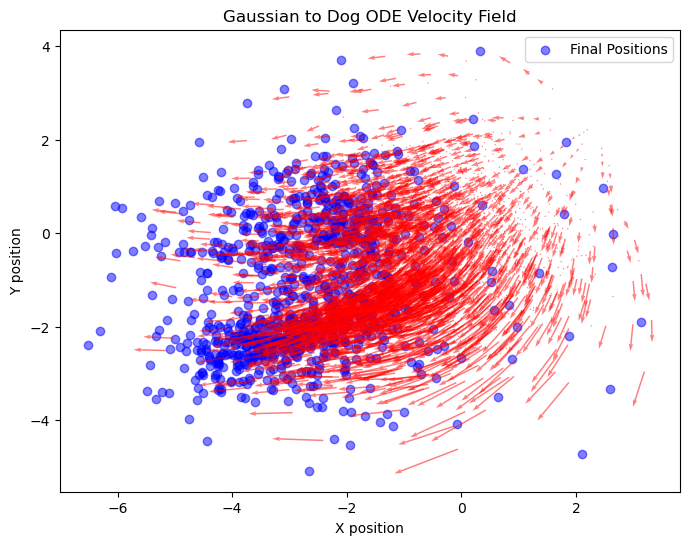

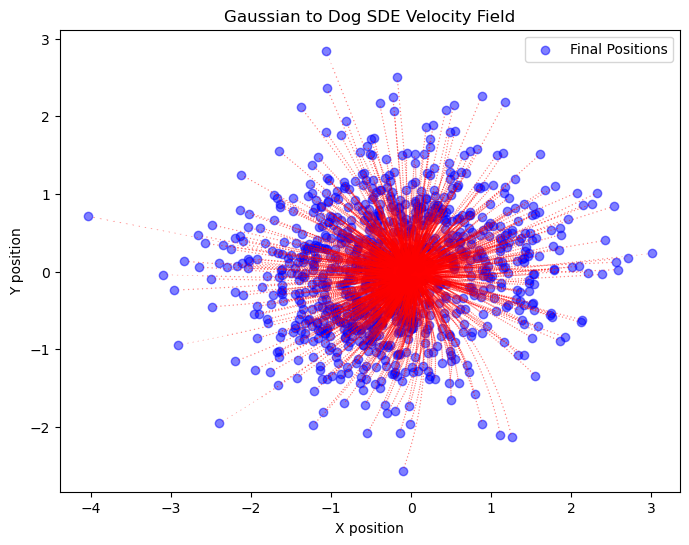

In [237]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

def compute_velocity(history):
    # velocity as difference b/w consecutive positions
    velocities = jnp.diff(history, axis=0) / dt  # difference b/w steps divided by time step
    return velocities

def visualize_velocity_field(history, velocities, step_interval=10, title="Velocity Field"):
    plt.figure(figsize=(8, 6))
    
    # positions at the final time step
    plt.scatter(history[-1][:, 0], history[-1][:, 1], color='blue', alpha=0.5, label='Final Positions')
    
    # velocity field using quiver
    for t in range(0, len(velocities), step_interval):
        x_pos = history[t][:, 0]
        y_pos = history[t][:, 1]
        u = velocities[t][:, 0]  # X of velocity
        v = velocities[t][:, 1]  # Y of velocity
        
        plt.quiver(x_pos, y_pos, u, v, color='red', alpha=0.5, scale=100)  # scale factor
    
    plt.title(title)
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.legend()
    plt.show()

# velocities
velocities_ode = compute_velocity(history_ode)  
velocities_sde = compute_velocity(history_sde)

visualize_velocity_field(history_ode, velocities_ode, step_interval=10, title="Gaussian to Dog ODE Velocity Field")
visualize_velocity_field(history_sde, velocities_sde, step_interval=10, title="Gaussian to Dog SDE Velocity Field")



## Cats to Dogs

Epoch 0, Train Loss: 0.5395045876502991, Val Loss: 0.476581335067749
Score Function (5 samples)
[[-7.1384900e+06 -3.4328380e+07]
 [-4.2488309e+04 -3.2202516e+05]
 [-8.5961074e+03 -8.4337352e+04]
 [-6.5318511e+03 -3.4165133e+04]
 [-3.3745051e+03 -1.7846016e+04]]
Epoch 50, Train Loss: 0.3127610981464386, Val Loss: 0.2957959771156311
Score Function (5 samples)
[[-1.2883256e+07 -6.5829440e+06]
 [ 4.3851729e+03 -1.4424683e+05]
 [ 1.2634869e+04 -4.5838770e+04]
 [-8.4086592e+03 -8.0421875e+03]
 [-3.6505439e+03 -3.9207173e+03]]
Epoch 100, Train Loss: 0.18857863545417786, Val Loss: 0.1990424245595932
Score Function (5 samples)
[[-2.5126412e+07 -9.8299580e+06]
 [ 9.5620805e+04 -3.6633622e+05]
 [ 4.9960520e+04 -1.2294784e+05]
 [-1.2577043e+04 -1.4256551e+04]
 [-4.1568242e+03 -6.7704297e+03]]
Epoch 150, Train Loss: 0.13249310851097107, Val Loss: 0.17376314103603363
Score Function (5 samples)
[[-2.9697764e+07 -2.0897266e+07]
 [ 5.3010625e+04 -3.9828338e+05]
 [ 3.5479758e+04 -1.2921131e+05]
 [-1.410

,Epoch,Training Loss,Validation Loss,Predicted Train Residual (Last Entry),Final Train Score (Last Entry),Predicted Val Residual (Last Entry),Final Val Score (Last Entry)
0,0,0.5395046,0.47658134,"[-0.154, -0.199]","[-0.241, -0.310]","[-0.164, -0.225]","[-0.164, -0.225]"
1,50,0.3127611,0.29579598,"[-0.405, 0.480]","[-0.634, 0.750]","[-0.361, 0.420]","[-0.361, 0.420]"
2,100,0.18857864,0.19904242,"[-0.619, 1.203]","[-0.967, 1.881]","[-0.520, 1.060]","[-0.520, 1.060]"
3,150,0.13249311,0.17376314,"[-0.324, 1.400]","[-0.507, 2.188]","[-0.239, 1.248]","[-0.239, 1.248]"
4,200,0.087785944,0.11024469,"[-0.243, 1.503]","[-0.379, 2.349]","[-0.157, 1.240]","[-0.157, 1.240]"
5,250,0.07063744,0.07593358,"[-0.252, 1.497]","[-0.394, 2.340]","[-0.229, 1.118]","[-0.229, 1.118]"
6,300,0.06982747,0.07544912,"[-0.250, 1.510]","[-0.391, 2.361]","[-0.215, 1.101]","[-0.215, 1.101]"
7,350,0.06954408,0.07553255,"[-0.243, 1.513]","[-0.380, 2.366]","[-0.196, 1.099]","[-0.196, 1.099]"
8,400,0.069355585,0.07577453,"[-0.244, 1.514]","[-0.381, 2.368]","[-0.188, 1.100]","[-0.188, 1.100]"
9,450,0.06925154,0.07611052,"[-0.245, 1.516]","[-0.384, 2.370]","[-0.186, 1.101]","[-0.186, 1.101]"


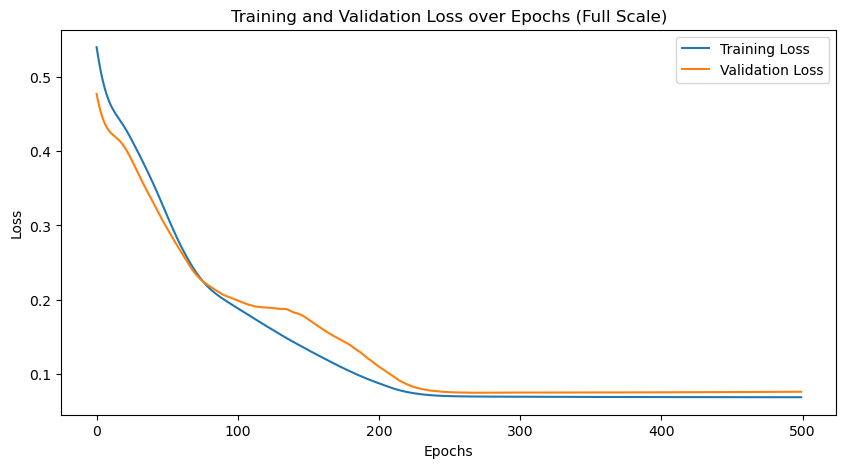

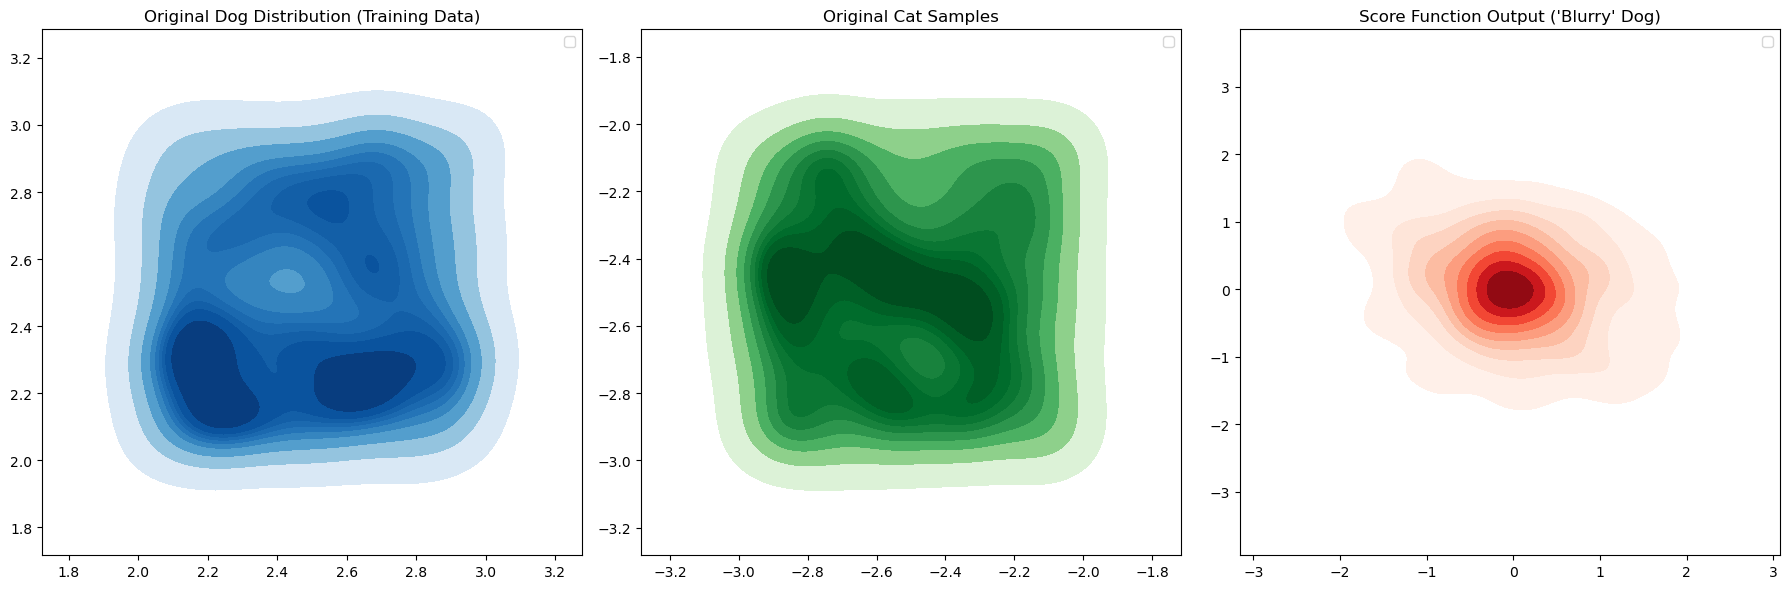

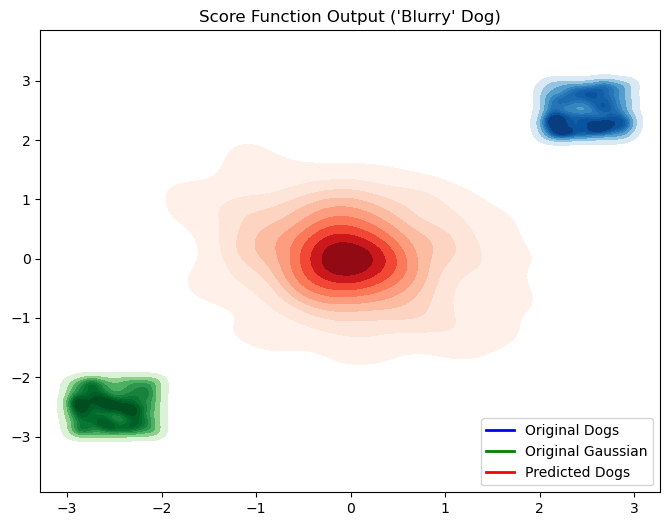

Number of Function Evaluations (NFE): 40


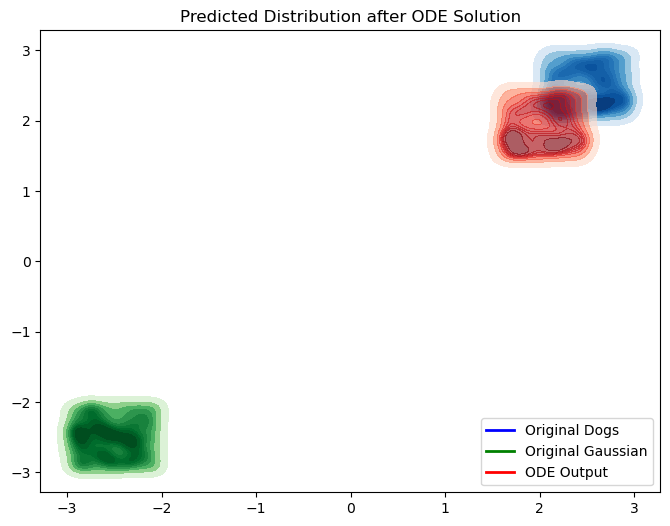

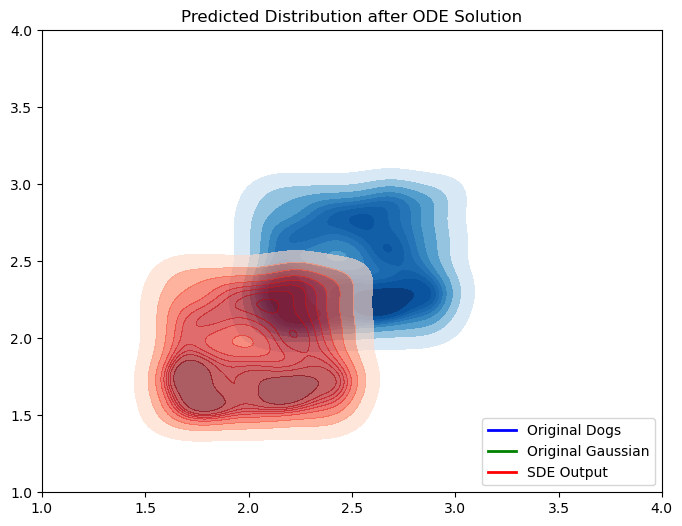

Number of Function Evaluations (NFE): 40
MSE between ODE output and Dog samples: 0.2601572275161743
Wasserstein Distance between ODE output and Dog samples: 1.0148986592888831


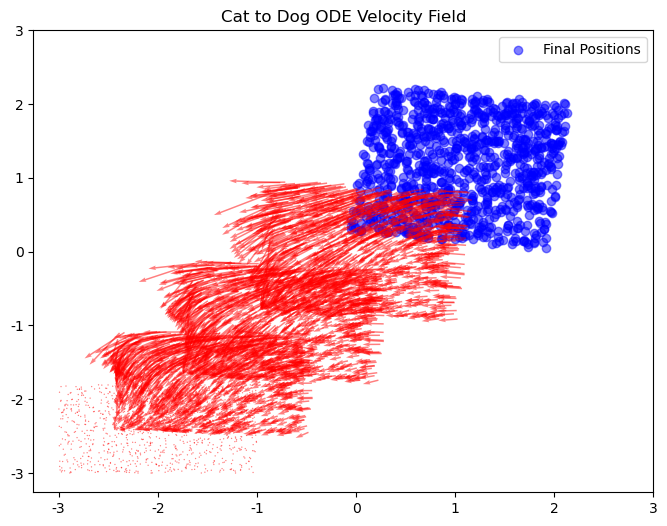

,Description,Value
0,Model,"ODE (Euler Method), Interpolation"
1,Mapping,Cat to Dog
2,ODE Parameters,"T = 1, N = 40, dt = 0.025"
3,Scaling Factor (s),1.000
4,Number of Function Evaluations (NFE),40
5,MSE,0.26016
6,Wasserstein Distance,1.01490


In [261]:
"""
CATS TO DOGS

"""

import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from scipy.stats import wasserstein_distance

class ScoreNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, key):
        self.params = self.init_params(input_dim, hidden_dims, output_dim, key)

    def init_params(self, input_dim, hidden_dims, output_dim, key):
        scale = .15  # small initialisation scale
        keys = random.split(key, len(hidden_dims) + 2)
        params = {}

        params['w0'] = scale * random.normal(keys[0], (input_dim, hidden_dims[0]))
        params['b0'] = jnp.zeros(hidden_dims[0])

        for i in range(1, len(hidden_dims)):
            params[f'w{i}'] = scale * random.normal(keys[i], (hidden_dims[i-1], hidden_dims[i]))
            params[f'b{i}'] = jnp.zeros(hidden_dims[i])

        params[f'w{len(hidden_dims)}'] = scale * random.normal(keys[-2], (hidden_dims[-1], output_dim))
        params[f'b{len(hidden_dims)}'] = jnp.zeros(output_dim)

        return params

    def forward(self, params, x):
        h = jax.nn.relu(jnp.dot(x, params['w0']) + params['b0'])
        for i in range(1, len(params) // 2 - 1):
            h = jax.nn.relu(jnp.dot(h, params[f'w{i}']) + params[f'b{i}'])
        out = jnp.dot(h, params[f'w{len(params)//2 - 1}']) + params[f'b{len(params)//2 - 1}']
        return out

# Setup
key = random.PRNGKey(0)
input_dim = 3
hidden_dims = [28, 28]
output_dim = 2
b = 0.07

# Initialise score network
score_net = ScoreNetwork(input_dim, hidden_dims, output_dim, key)
n_samples = cat_samples.shape[0]  # Use cat samples instead of Gaussian samples

# Split (train/val, 80/20)
split_idx = int(0.8 * n_samples)
x_train = cat_samples[:split_idx]  # cat samples for training
x_val = cat_samples[split_idx:]
dog_train = dog_samples[:split_idx]
dog_val = dog_samples[split_idx:]
cat_start = x_train  

# Generate time-dependent noise for x_train, x_val
sigma_t_train = jnp.sqrt(jnp.linspace(0, 1, split_idx))
sigma_t_val = jnp.sqrt(jnp.linspace(0, 1, n_samples - split_idx))

# Add Gaussian noise with variance based on sigma(t)
x_train = dog_train + sigma_t_train[:, None] * random.normal(key, shape=dog_train.shape)
x_val = dog_val + sigma_t_val[:, None] * random.normal(key, shape=dog_val.shape)

# True score approximation: difference b/w dog samples and noisy cat samples
true_scores_train = dog_train - x_train
true_scores_val = dog_val - x_val

# Time steps
time_steps = jnp.linspace(0, 1, n_samples)
time_steps_train = time_steps[:split_idx]
time_steps_val = time_steps[split_idx:]

# Concat inputs
x_input_train = jnp.concatenate([x_train, time_steps_train[:, None]], axis=1)
x_input_val = jnp.concatenate([x_val, time_steps_val[:, None]], axis=1)

# Optimizer 
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(score_net.params)

# Loss (MMSE with residual prediction)
def loss_fn(params, x, clean_data):
    predicted_residual = score_net.forward(params, x)
    loss = jnp.mean((predicted_residual - (clean_data - x[:, :2])) ** 2)
    return loss

# MSE b/w predicted and true distributions
def compute_mse(predicted, true):
    return jnp.mean(jnp.square(predicted - true))

# Wasserstein Distance b/w predicted and true distributions
def compute_wasserstein(predicted, true):
    # compute W-dist separately for ea. dim and sum
    wd_x = wasserstein_distance(predicted[:, 0], true[:, 0])
    wd_y = wasserstein_distance(predicted[:, 1], true[:, 1])
    return wd_x + wd_y

# Update grads
@jax.jit
def update(params, x, clean_data, opt_state):
    grads = jax.grad(loss_fn)(params, x, clean_data)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

# Training loop (no batching, for simplicity)
num_epochs = 500
train_losses = []
val_losses = []
score_function_evolution = []
epochs_all = list(range(1, num_epochs + 1))

train_losses_pdtable = []
val_losses_pdtable = []
epochs_pdtable = []
predicted_residual_train_pdtable = []
predicted_residual_val_pdtable = []
final_train_scores_pdtable = []
final_val_scores_pdtable = []

for epoch in range(num_epochs):
    score_net.params, opt_state = update(score_net.params, x_input_train, dog_train, opt_state)
    train_loss = loss_fn(score_net.params, x_input_train, dog_train)
    val_loss = loss_fn(score_net.params, x_input_val, dog_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        train_losses_pdtable.append(train_loss)
        val_losses_pdtable.append(val_loss)
        epochs_pdtable.append(epoch)
        
        # get score function for subset of training data 
        t_sample = time_steps_train[:5]
        x_sample = x_input_train[:5]
        
        # predict residual, calculate score
        predicted_residual = score_net.forward(score_net.params, x_sample)
        score_function = predicted_residual / (jnp.square(t_sample)[:, None] + 1e-8)

        predicted_residual_train = score_net.forward(score_net.params, x_input_train)
        predicted_residual_val = score_net.forward(score_net.params, x_input_val)

        predicted_residual_train_pdtable.append(f"[{predicted_residual_train[-1][0]:.3f}, {predicted_residual_train[-1][1]:.3f}]")
        predicted_residual_val_pdtable.append(f"[{predicted_residual_val[-1][0]:.3f}, {predicted_residual_val[-1][1]:.3f}]")

        score_function_train = predicted_residual_train / (jnp.square(time_steps_train[:, None]) + 1e-8)
        score_function_val = predicted_residual_val / (jnp.square(time_steps_val[:, None]) + 1e-8)

        final_train_scores_pdtable.append(f"[{score_function_train[-1][0]:.3f}, {score_function_train[-1][1]:.3f}]")
        final_val_scores_pdtable.append(f"[{score_function_val[-1][0]:.3f}, {score_function_val[-1][1]:.3f}]")
        
        print(f"Score Function (5 samples)")
        print(score_function)
        score_function_evolution.append(score_function)

    if epoch == num_epochs - 1:
        print(f'Epoch {epoch}, Final Train Loss: {train_loss}, Final Val Loss: {val_loss}')
        
        train_losses_pdtable.append(train_loss)
        val_losses_pdtable.append(val_loss)
        epochs_pdtable.append(epoch + 1)

        predicted_residual_train = score_net.forward(score_net.params, x_input_train)
        predicted_residual_val = score_net.forward(score_net.params, x_input_val)

        predicted_residual_train_pdtable.append(f"[{predicted_residual_train[-1][0]:.3f}, {predicted_residual_train[-1][1]:.3f}]")
        predicted_residual_val_pdtable.append(f"[{predicted_residual_val[-1][0]:.3f}, {predicted_residual_val[-1][1]:.3f}]")

        score_function_train = predicted_residual_train / (jnp.square(time_steps_train[:, None]) + 1e-8)
        score_function_val = predicted_residual_val / (jnp.square(time_steps_val[:, None]) + 1e-8)

        final_train_scores_pdtable.append(f"[{score_function_train[-1][0]:.3f}, {score_function_train[-1][1]:.3f}]")
        final_val_scores_pdtable.append(f"[{score_function_val[-1][0]:.3f}, {score_function_val[-1][1]:.3f}]")

        # final score function, all training data
        final_score_train = score_net.forward(score_net.params, x_input_train)
        final_score_function_train = final_score_train / (jnp.square(time_steps_train[:, None]) + 1e-8)
        
        # final score function, all validation data
        final_score_val = score_net.forward(score_net.params, x_input_val)
        final_score_function_val = final_score_val / (jnp.square(time_steps_val[:, None]) + 1e-8)
        
        print(f"Final Score Function (Train):\n{final_score_function_train}")
        print(f"Final Score Function (Validation):\n{final_score_function_val}")

pred_train = score_net.forward(score_net.params, x_input_train)  # train predictions
pred_val = score_net.forward(score_net.params, x_input_val)  # val predictions

# RESULTS OUTPUT

data = {
    'Epoch': epochs_pdtable,
    'Training Loss': train_losses_pdtable,
    'Validation Loss': val_losses_pdtable,
    'Predicted Train Residual (Last Entry)': predicted_residual_train_pdtable,
    'Final Train Score (Last Entry)': final_train_scores_pdtable,
    'Predicted Val Residual (Last Entry)': predicted_residual_val_pdtable,
    'Final Val Score (Last Entry)': final_val_scores_pdtable
}

df_losses = pd.DataFrame(data)
display(df_losses)

# Losses (full scale)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs (Full Scale)")
plt.show()


# visualise density plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, ax=axs[0])
axs[0].set_title("Original Dog Distribution (Training Data)")
axs[0].legend(['Original Dogs (Train)'])

sns.kdeplot(x=cat_start[:, 0], y=cat_start[:, 1], cmap="Greens", fill=True, ax=axs[1])
axs[1].set_title("Original Cat Samples")
axs[1].legend(['Original Cats'])

sns.kdeplot(x=pred_train[:, 0], y=pred_train[:, 1], cmap="Reds", fill=True, ax=axs[2])
axs[2].set_title("Score Function Output ('Blurry' Dog)")
axs[2].legend(['Blurry Dog'])

plt.tight_layout()
plt.show()

def compute_velocity(history):
    # velocity as difference b/t consecutive positions
    velocities = jnp.diff(history, axis=0) / dt  # difference b/w steps divided by time step
    return velocities

def visualize_velocity_field(history, velocities, step_interval=10, title="Velocity Field"):
    plt.figure(figsize=(8, 6))
    
    # positions at the final time step
    plt.scatter(history[-1][:, 0], history[-1][:, 1], color='blue', alpha=0.5, label='Final Positions')
    
    # velocity field using quiver
    for t in range(0, len(velocities), step_interval):
        x_pos = history[t][:, 0]
        y_pos = history[t][:, 1]
        u = velocities[t][:, 0]  
        v = velocities[t][:, 1]  
        plt.quiver(x_pos, y_pos, u, v, color='red', alpha=0.5, scale=100)  # Adjust the scale factor

    plt.title(title)
    x_tick_positions = np.linspace(2, 5, 7)
    y_tick_positions = np.linspace(2, 7, 7)
    tick_labels = ["-3","-2","-1","0","1","2","3"]
    plt.xticks(x_tick_positions, tick_labels) 
    plt.yticks(y_tick_positions, tick_labels) 
    plt.legend()
    plt.show()

# combined plot: original dog, original cat, blurry dogs (score)
plt.figure(figsize=(8, 6))

sns.kdeplot(x=pred_train[:, 0], y=pred_train[:, 1], cmap="Reds", fill=True, alpha=1)
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=cat_start[:, 0], y=cat_start[:, 1], cmap="Greens", fill=True, alpha=1)

dog_handle = mlines.Line2D([], [], color='blue', label='Original Dogs', linewidth=2)
gaussian_handle = mlines.Line2D([], [], color='green', label='Original Gaussian', linewidth=2)
pred_handle = mlines.Line2D([], [], color='red', label='Predicted Dogs', linewidth=2)

plt.title("Score Function Output ('Blurry' Dog)")
plt.legend(handles=[dog_handle, gaussian_handle, pred_handle], loc="lower right")

plt.show()


    

"""
# RESULTS OUTPUT

"""

import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import seaborn as sns

# ODE parameters
T = 1  
N = 40  
dt = T / N  
t_values = jnp.linspace(0, T, N)  

# Solve ODE using Euler method
def solve_ode(x_init, score_net, params, key):
    x = x_init
    history = [x]  
    NFE = 0  
    
    for t in t_values:
        t = jnp.array([t])  
        t_repeated = jnp.repeat(t[:, None], repeats=x.shape[0], axis=0)  
        
        # Predict residual and calculate score (function evaluation)
        predicted_residual = score_net.forward(params, jnp.concatenate([x, t_repeated], axis=1))
        score = predicted_residual / (jnp.square(t) + 1e-8)  # scaling
        
        # Euler update for ODE (DETERMINISTIC)
        x = x - t ** 2 * score * dt
        
        NFE += 1
        history.append(x)  # Save state

    print(f"Number of Function Evaluations (NFE): {NFE}")
    return jnp.array(history), NFE  # Return the history and NFE count

# Initial condition (cat samples)
key = random.PRNGKey(0)
x_init = generate_uniform_samples(key, n_samples, lower_corner=-3.0, upper_corner=-2.0)
s = 1

history_ode, total_NFE_ode = solve_ode(x_init, score_net, score_net.params, key)
history_ode = s * history_ode  # scaling factor of 1

# shape matching
n_samples_adjusted = min(history_ode[-1].shape[0], dog_train.shape[0])

history_ode_adjusted = history_ode[-1]
history_ode_adjusted = b * history_ode_adjusted + (1 - b) * test_samples
history_final = history_ode_adjusted[:n_samples_adjusted, :]
dog_train_adjusted = dog_train[:n_samples_adjusted, :]

# Metrics: MSE, Wasserstein
mse_ode = compute_mse(history_final, dog_train_adjusted)
wasserstein_dist_ode = compute_wasserstein(history_final, dog_train_adjusted)

# final distribution(s)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=cat_start[:, 0], y=cat_start[:, 1], cmap="Greens", fill=True, alpha=1)
sns.kdeplot(x=history_final[:, 0], y=history_final[:, 1], cmap="Reds", fill=True, alpha=0.65)

dog_handle = mlines.Line2D([], [], color='blue', label='Original Dogs', linewidth=2)
gaussian_handle = mlines.Line2D([], [], color='green', label='Original Gaussian', linewidth=2)
ode_handle = mlines.Line2D([], [], color='red', label='ODE Output', linewidth=2)

plt.title("Predicted Distribution after ODE Solution")
plt.legend(handles=[dog_handle, gaussian_handle, ode_handle], loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True, alpha=1)
sns.kdeplot(x=cat_start[:, 0], y=cat_start[:, 1], cmap="Greens", fill=True, alpha=0.4)
sns.kdeplot(x=history_final[:, 0], y=history_final[:, 1], cmap="Reds", fill=True, alpha=0.65)

plt.xlim(1, 4)
plt.ylim(1, 4)
plt.title("Predicted Distribution after ODE Solution")
plt.legend(handles=[dog_handle, gaussian_handle, sde_handle], loc="lower right")
plt.show()

print(f"Number of Function Evaluations (NFE): {total_NFE_ode}")
print(f"MSE between ODE output and Dog samples: {mse_ode}")
print(f"Wasserstein Distance between ODE output and Dog samples: {wasserstein_dist_ode}")

history_ode = history_ode.at[..., 0].set(-history_ode[..., 0]) 
history_ode = history_ode.at[..., 1].set(-history_ode[..., 1]) 
velocities_ode = velocities_ode.at[..., 0].set(-velocities_ode[..., 0])  
velocities_ode = velocities_ode.at[..., 1].set(-velocities_ode[..., 1])  
visualize_velocity_field(history_ode, -velocities_ode, step_interval=10, title="Cat to Dog ODE Velocity Field")

data = {
    "Description": ["Model", "Mapping", "ODE Parameters", "Scaling Factor (s)", "Number of Function Evaluations (NFE)", "MSE", "Wasserstein Distance"],
    "Value": [
        "ODE (Euler Method), Interpolation",    
        "Cat to Dog",                                    
        f"T = {T}, N = {N}, dt = {dt:.3f}",                   
        f"{s:.3f}",                                           
        f"{total_NFE_ode}",                                       
        f"{mse_ode:.5f}",                                         
        f"{wasserstein_dist_ode:.5f}"
    ]
}

df = pd.DataFrame(data)
display(df)


### Scratch

Epoch 0, Train Loss: 0.5263391137123108, Val Loss: 0.4868553876876831
Score Function for first 5 samples at epoch 0:
[[-1.26157094e+05  1.01856016e+05]
 [-1.22485852e+03  9.92804138e+02]
 [-3.08476257e+02  2.48905670e+02]
 [-1.37480316e+02  1.12371666e+02]
 [-7.66568451e+01  6.31902390e+01]]
Epoch 500, Train Loss: 0.07130252569913864, Val Loss: 0.07291898876428604
Score Function for first 5 samples at epoch 500:
[[-9879497.     4547691.5  ]
 [  328117.22    -96168.31 ]
 [   97797.28    -63726.215]
 [   21410.867    21071.88 ]
 [   21128.258    19828.855]]


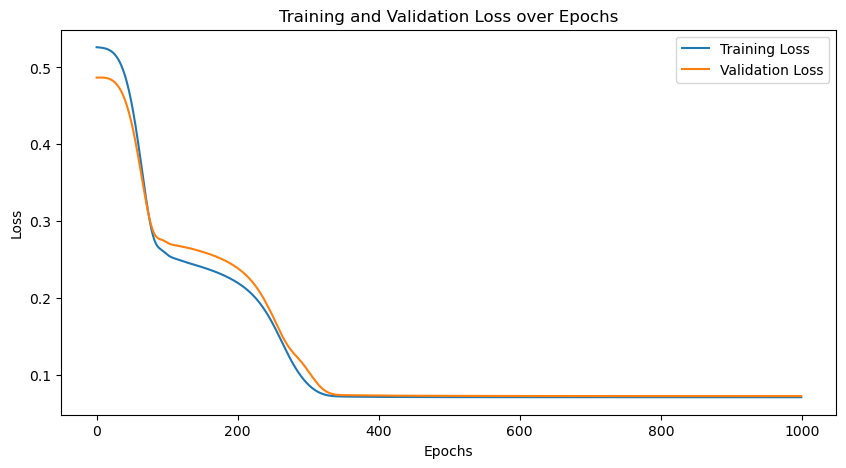

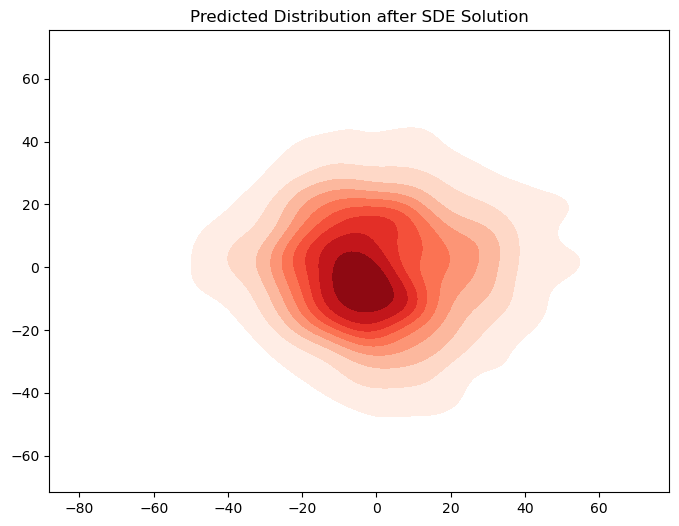

In [596]:
######################################### SDE Scratch

import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import seaborn as sns

class ScoreNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, key):
        self.params = self.init_params(input_dim, hidden_dims, output_dim, key)

    def init_params(self, input_dim, hidden_dims, output_dim, key):
        scale = 0.01 # smaller initialisation scale
        keys = random.split(key, len(hidden_dims) + 2)
        params = {}

        params['w0'] = scale * random.normal(keys[0], (input_dim, hidden_dims[0]))
        params['b0'] = jnp.zeros(hidden_dims[0])

        for i in range(1, len(hidden_dims)):
            params[f'w{i}'] = scale * random.normal(keys[i], (hidden_dims[i-1], hidden_dims[i]))
            params[f'b{i}'] = jnp.zeros(hidden_dims[i])

        params[f'w{len(hidden_dims)}'] = scale * random.normal(keys[-2], (hidden_dims[-1], output_dim))
        params[f'b{len(hidden_dims)}'] = jnp.zeros(output_dim)

        return params

    def forward(self, params, x):
        h = jax.nn.relu(jnp.dot(x, params['w0']) + params['b0'])
        for i in range(1, len(params) // 2 - 1):
            h = jax.nn.relu(jnp.dot(h, params[f'w{i}']) + params[f'b{i}'])
        out = jnp.dot(h, params[f'w{len(params)//2 - 1}']) + params[f'b{len(params)//2 - 1}']
        return out

# Score Netwrok
key = random.PRNGKey(0)
input_dim = 3  # x in R^2 and t in R, so input dims = 3
hidden_dims = [32, 24]  # two hidden layers, 32 and 24 nodes
output_dim = 2  # score function in R^2

score_net = ScoreNetwork(input_dim, hidden_dims, output_dim, key)

n_samples = gaussian_samples.shape[0]

split_idx = int(0.8 * n_samples)
x_train = gaussian_samples[:split_idx]
x_val = gaussian_samples[split_idx:]
dog_train = dog_samples[:split_idx]
dog_val = dog_samples[split_idx:]

sigma_t_train = jnp.sqrt(jnp.linspace(0, 1, split_idx))
sigma_t_val = jnp.sqrt(jnp.linspace(0, 1, n_samples - split_idx))

x_train = dog_train + sigma_t_train[:, None] * random.normal(key, shape=dog_train.shape)
x_val = dog_val + sigma_t_val[:, None] * random.normal(key, shape=dog_val.shape)

true_scores_train = dog_train - x_train
true_scores_val = dog_val - x_val

time_steps = jnp.linspace(0, 1, n_samples)
time_steps_train = time_steps[:split_idx]
time_steps_val = time_steps[split_idx:]

x_input_train = jnp.concatenate([x_train, time_steps_train[:, None]], axis=1)
x_input_val = jnp.concatenate([x_val, time_steps_val[:, None]], axis=1)

learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(score_net.params)

# loss, update, training
def loss_fn(params, x, clean_data):
    predicted_residual = score_net.forward(params, x)
    loss = jnp.mean((predicted_residual - (clean_data - x[:, :2])) ** 2)
    return loss

@jax.jit
def update(params, x, clean_data, opt_state):
    grads = jax.grad(loss_fn)(params, x, clean_data)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

num_epochs = 1000
train_losses = []
val_losses = []
score_function_evolution = []

for epoch in range(num_epochs):
    score_net.params, opt_state = update(score_net.params, x_input_train, dog_train, opt_state)

    train_loss = loss_fn(score_net.params, x_input_train, dog_train)
    val_loss = loss_fn(score_net.params, x_input_val, dog_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        t_sample = time_steps_train[:5]
        x_sample = x_input_train[:5]
        predicted_residual = score_net.forward(score_net.params, x_sample)
        score_function = predicted_residual / (jnp.square(t_sample)[:, None] + 1e-8)
        print(f"Score Function for first 5 samples at epoch {epoch}:")
        print(score_function)
        score_function_evolution.append(score_function)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

# SDE parameters
T = 1.0
N = 1000
dt = T / N
t_values = jnp.linspace(0, T, N)

def solve_sde(x_init, score_net, params, key):
    x = x_init
    history = [x]
    key, subkey = random.split(key)

    for t in t_values:
        noise = random.normal(subkey, shape=x.shape)
        t = jnp.array([t])
        t_repeated = jnp.repeat(t[:, None], repeats=x.shape[0], axis=0)
        predicted_residual = score_net.forward(params, jnp.concatenate([x, t_repeated], axis=1))
        score = predicted_residual / (jnp.square(t) + 1e-8)
        x = x - t ** 2 * score * dt + t * jnp.sqrt(dt) * noise
        history.append(x)

    return jnp.array(history)

key = random.PRNGKey(0)
x_init = random.normal(key, (n_samples, 2))

history = solve_sde(x_init, score_net, score_net.params, key)

plt.figure(figsize=(8, 6))
sns.kdeplot(x=history[-1][:, 0], y=history[-1][:, 1], cmap="Reds", fill=True)
plt.title("Predicted Distribution after SDE Solution")
plt.show()


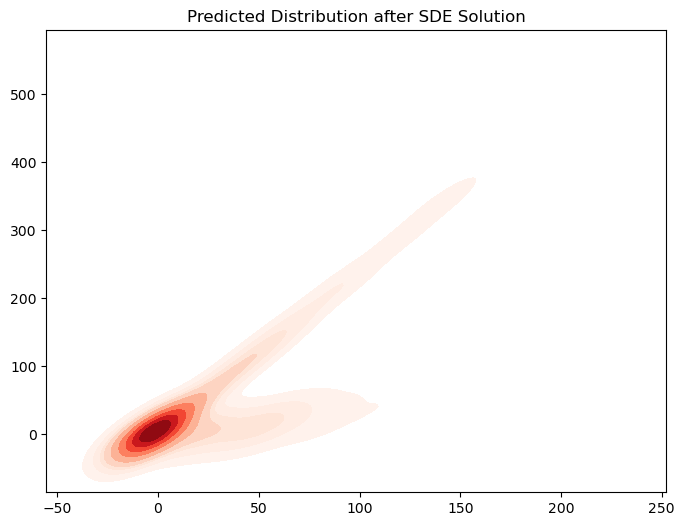

In [90]:
######################################### SDE Scratch

import jax.numpy as jnp
import jax
import optax
import matplotlib.pyplot as plt
from jax import random

T = 1.0
N = 1000
dt = T / N
t_values = jnp.linspace(0, T, N)

def solve_sde(x_init, score_net, params, key):
    x = x_init
    history = [x]
    key, subkey = random.split(key)
    
    for t in t_values:
        noise = random.normal(subkey, shape=x.shape)
        t = jnp.array([t])
        t_repeated = jnp.repeat(t[:, None], repeats=x.shape[0], axis=0)
        score = score_net.forward(params, jnp.concatenate([x, t_repeated], axis=1))
        x = x - t ** 2 * score * dt + t * jnp.sqrt(dt) * noise
        history.append(x)

    return jnp.array(history)

key = random.PRNGKey(0)
x_init = random.normal(key, (n_samples, 2))

history = solve_sde(x_init, score_net, score_net.params, key)

plt.figure(figsize=(8, 6))
sns.kdeplot(x=history[-1][:, 0], y=history[-1][:, 1], cmap="Reds", fill=True)
plt.title("Predicted Distribution after SDE Solution")
plt.show()


Epoch 0, Train Loss: 223240.8125, Val Loss: 232984.390625
Epoch 1000, Train Loss: 6.270440578460693, Val Loss: 17.575719833374023
Epoch 2000, Train Loss: 2.0085906982421875, Val Loss: 6.949291706085205
Epoch 3000, Train Loss: 1.1127296686172485, Val Loss: 4.889604568481445
Epoch 4000, Train Loss: 0.7269631028175354, Val Loss: 4.389753818511963
Epoch 4999, Final Train Loss: 0.503863513469696, Final Val Loss: 3.390277862548828
Final Network Output (Predicted Scores):
[[ 0.7935698  -0.1865382 ]
 [-1.158634    1.1960721 ]
 [ 0.588135    1.2063527 ]
 [ 1.2731402  -0.26324415]
 [ 1.1910956  -0.36151457]]
Final Network Output (Validation):
[[-0.7691858  -2.2092624 ]
 [ 3.3942719   1.4222493 ]
 [ 1.6841086   0.20460941]
 [-0.5681865  -1.3025928 ]
 [-0.6018703  -1.930614  ]]


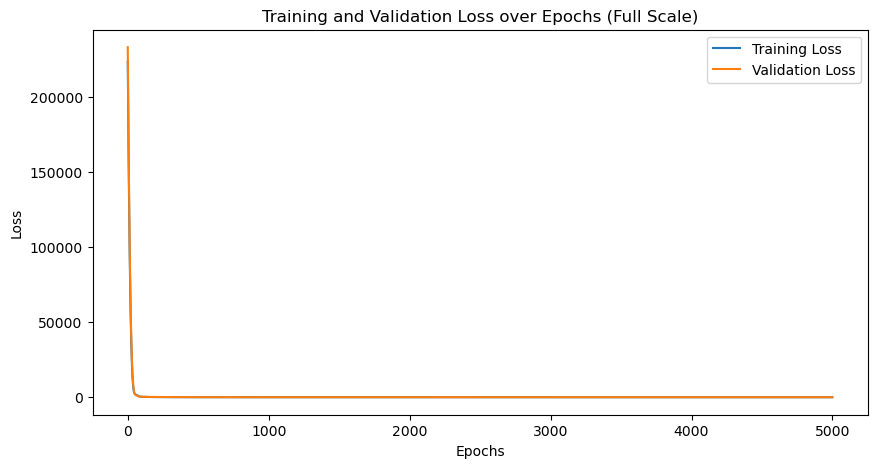

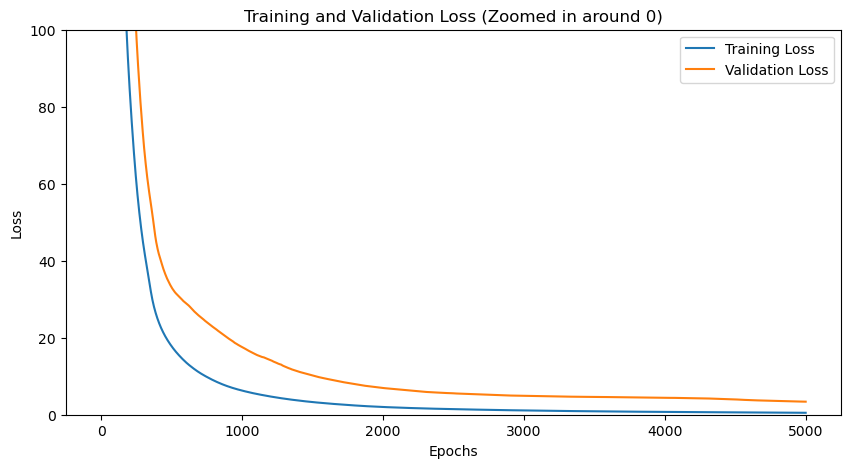

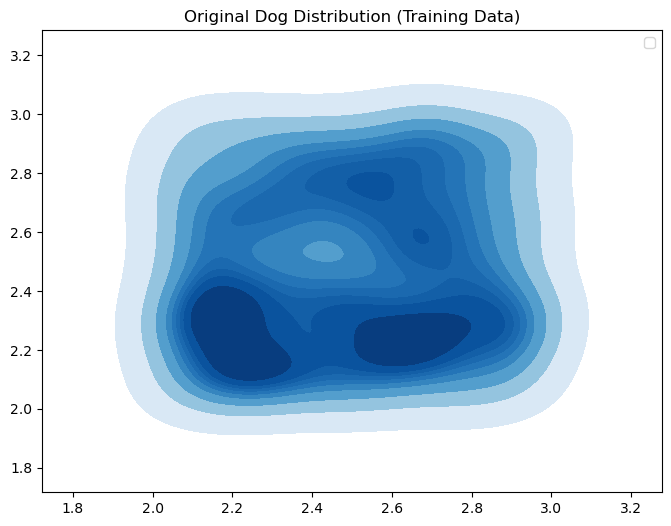

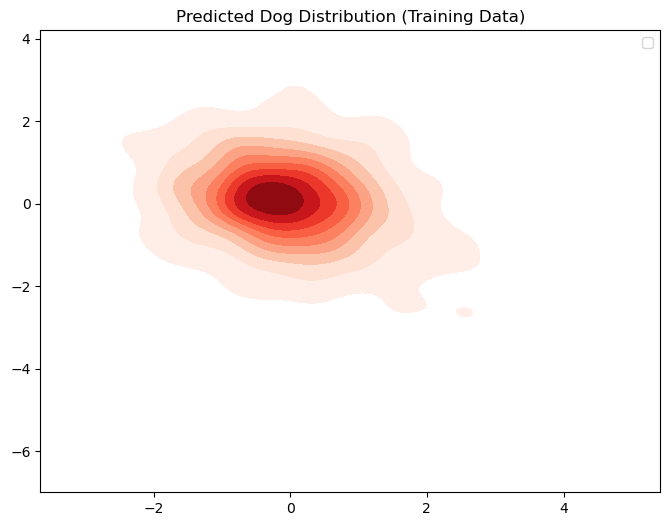

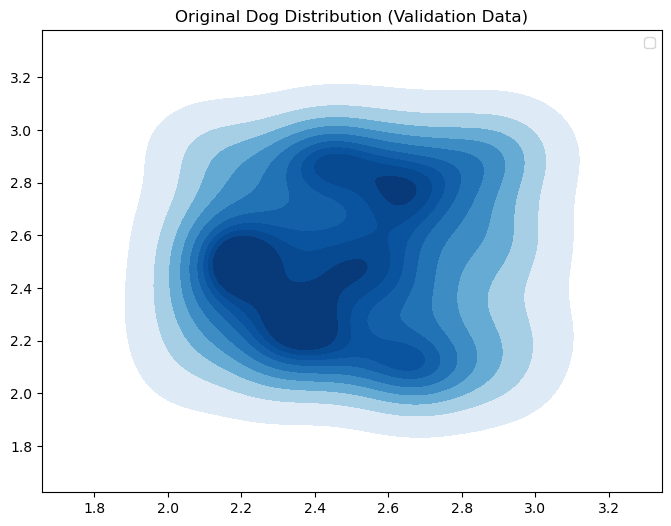

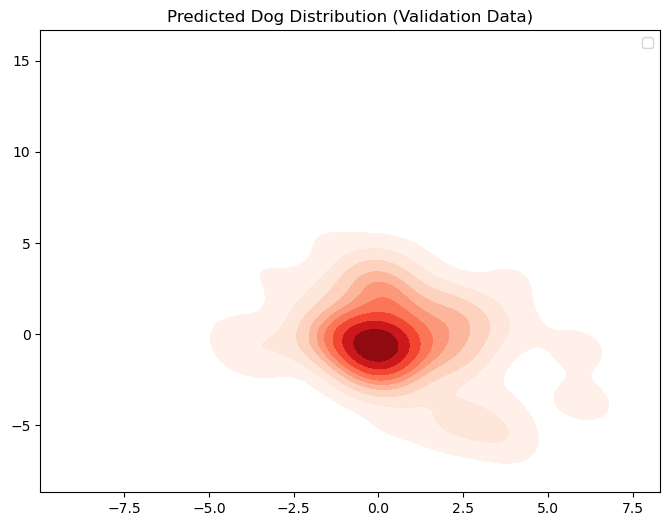

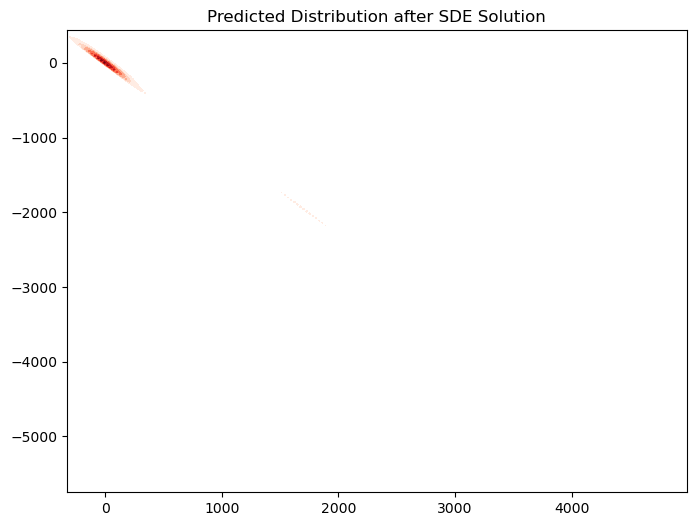

In [598]:
######################################### SDE Scratch

import jax
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt
import seaborn as sns

class ScoreNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, key):
        self.params = self.init_params(input_dim, hidden_dim, output_dim, key)

    def init_params(self, input_dim, hidden_dim, output_dim, key):
        keys = random.split(key, 4)
        params = {
            'w1': random.normal(keys[0], (input_dim, hidden_dim)),
            'b1': jnp.zeros(hidden_dim),
            'w2': random.normal(keys[1], (hidden_dim, hidden_dim)),
            'b2': jnp.zeros(hidden_dim),
            'w3': random.normal(keys[2], (hidden_dim, output_dim)),
            'b3': jnp.zeros(output_dim)
        }
        return params

    def forward(self, params, x):
        h1 = jnp.dot(x, params['w1']) + params['b1']
        h1 = jax.nn.relu(h1)
        h2 = jnp.dot(h1, params['w2']) + params['b2']
        h2 = jax.nn.relu(h2)
        out = jnp.dot(h2, params['w3']) + params['b3']
        return out

key = random.PRNGKey(0)
input_dim = 3
hidden_dim = 128
output_dim = 2
score_net = ScoreNetwork(input_dim, hidden_dim, output_dim, key)

n_samples = gaussian_samples.shape[0]

split_idx = int(0.8 * n_samples)
x_train = gaussian_samples[:split_idx]
x_val = gaussian_samples[split_idx:]
dog_train = dog_samples[:split_idx]
dog_val = dog_samples[split_idx:]

sigma_t_train = jnp.sqrt(jnp.linspace(0, 1, split_idx))
sigma_t_val = jnp.sqrt(jnp.linspace(0, 1, n_samples - split_idx))

x_train = dog_train + sigma_t_train[:, None] * random.normal(key, shape=dog_train.shape)
x_val = dog_val + sigma_t_val[:, None] * random.normal(key, shape=dog_val.shape)

true_scores_train = dog_train - x_train
true_scores_val = dog_val - x_val

time_steps = jnp.linspace(0, 1, n_samples)
time_steps_train = time_steps[:split_idx]
time_steps_val = time_steps[split_idx:]

x_input_train = jnp.concatenate([x_train, time_steps_train[:, None]], axis=1)
x_input_val = jnp.concatenate([x_val, time_steps_val[:, None]], axis=1)

learning_rate = 0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(score_net.params)

def loss_fn(params, x, clean_data):
    predicted_residual = score_net.forward(params, x)
    loss = jnp.mean((predicted_residual - (clean_data - x[:, :2])) ** 2)
    return loss

@jax.jit
def update(params, x, clean_data, opt_state):
    grads = jax.grad(loss_fn)(params, x, clean_data)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

num_epochs = 5000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    score_net.params, opt_state = update(score_net.params, x_input_train, dog_train, opt_state)

    train_loss = loss_fn(score_net.params, x_input_train, dog_train)
    val_loss = loss_fn(score_net.params, x_input_val, dog_val)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        predicted_scores_train = score_net.forward(score_net.params, x_input_train[:5])
        predicted_scores_val = score_net.forward(score_net.params, x_input_val[:5])

    if epoch == num_epochs - 1:
        print(f'Epoch {epoch}, Final Train Loss: {train_loss}, Final Val Loss: {val_loss}')
        print(f'Final Network Output (Predicted Scores):\n{predicted_scores_train}')
        print(f'Final Network Output (Validation):\n{predicted_scores_val}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs (Full Scale)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss (Zoomed in around 0)")
plt.ylim(0, 100)
plt.show()

pred_train = score_net.forward(score_net.params, x_input_train)
pred_val = score_net.forward(score_net.params, x_input_val)

plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_train[:, 0], y=dog_train[:, 1], cmap="Blues", fill=True)
plt.title("Original Dog Distribution (Training Data)")
plt.legend(['Original Dogs (Train)'])
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(x=pred_train[:, 0], y=pred_train[:, 1], cmap="Reds", fill=True)
plt.title("Predicted Dog Distribution (Training Data)")
plt.legend(['Predicted Dogs (Train)'])
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(x=dog_val[:, 0], y=dog_val[:, 1], cmap="Blues", fill=True)
plt.title("Original Dog Distribution (Validation Data)")
plt.legend(['Original Dogs (Val)'])
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(x=pred_val[:, 0], y=pred_val[:, 1], cmap="Reds", fill=True)
plt.title("Predicted Dog Distribution (Validation Data)")
plt.legend(['Predicted Dogs (Val)'])
plt.show()

T = 1.0
N = 1000
dt = T / N
t_values = jnp.linspace(0, T, N)

def solve_sde(x_init, score_net, params, key):
    x = x_init
    history = [x]
    key, subkey = random.split(key)
    
    for t in t_values:
        noise = random.normal(subkey, shape=x.shape)
        t = jnp.array([t])
        t_repeated = jnp.repeat(t[:, None], repeats=x.shape[0], axis=0)
        predicted_residual = score_net.forward(params, jnp.concatenate([x, t_repeated], axis=1))
        score = (predicted_residual) / (jnp.square(t) + 1e-8)
        x = x - t ** 2 * score * dt + t * jnp.sqrt(dt) * noise
        history.append(x)

    return jnp.array(history)

key = random.PRNGKey(0)
x_init = random.normal(key, (n_samples, 2))

history = solve_sde(x_init, score_net, score_net.params, key)

plt.figure(figsize=(8, 6))
sns.kdeplot(x=history[-1][:, 0], y=history[-1][:, 1], cmap="Reds", fill=True)
plt.title("Predicted Distribution after SDE Solution")
plt.show()
